In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

In [58]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

# Objetivo

Você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA para criar uma série temporal e prever diariamente o fechamento da base.

- Apresentar modelo com storytelling;

- Justificar a técnica utilizada;

- Atingir acurácia mínimia de 70%.

**Dados**: https://br.investing.com/indices/bovespa-historical-data

# Leitura e processamento dos dados

In [2]:
dados_path = './data/dados_ibovespa_2010-2023.csv'

dados = pd.read_csv(dados_path)

dados

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,24.08.2023,117.026,118.135,118.136,116.848,"9,20M","-0,94%"
1,23.08.2023,118.135,116.160,118.135,116.159,"11,54M","1,70%"
2,22.08.2023,116.156,114.433,116.286,114.433,"9,83M","1,51%"
3,21.08.2023,114.429,115.404,115.425,114.067,"9,79M","-0,85%"
4,18.08.2023,115.409,114.973,115.729,114.423,"10,60M","0,37%"
...,...,...,...,...,...,...,...
3376,08.01.2010,70.263,70.455,70.766,70.158,"1,63M","-0,27%"
3377,07.01.2010,70.451,70.723,70.723,70.045,"1,55M","-0,39%"
3378,06.01.2010,70.729,70.237,70.937,70.016,"2,24M","0,70%"
3379,05.01.2010,70.240,70.046,70.595,69.928,"1,98M","0,28%"


In [3]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      3381 non-null   object 
 1   Último    3381 non-null   float64
 2   Abertura  3381 non-null   float64
 3   Máxima    3381 non-null   float64
 4   Mínima    3381 non-null   float64
 5   Vol.      3380 non-null   object 
 6   Var%      3381 non-null   object 
dtypes: float64(4), object(3)
memory usage: 185.0+ KB
None


In [4]:
print(dados.isna().sum())

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64


Existem algumas inconsistências na base. Coluna de data está como tipo texto, variáveis numéricas em formato texto e existe um valor nulo na coluna "Vol."

## Ajuste nos tipos de dados

In [5]:
# Coluna Data com tipo datetime
dados = pd.read_csv(dados_path, parse_dates=[0], dayfirst=True)

dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2023-08-24,117.026,118.135,118.136,116.848,"9,20M","-0,94%"
1,2023-08-23,118.135,116.160,118.135,116.159,"11,54M","1,70%"
2,2023-08-22,116.156,114.433,116.286,114.433,"9,83M","1,51%"
3,2023-08-21,114.429,115.404,115.425,114.067,"9,79M","-0,85%"
4,2023-08-18,115.409,114.973,115.729,114.423,"10,60M","0,37%"


In [6]:
dados['Vol.'] = dados['Vol.'].str[:-1]
dados['Var%'] = dados['Var%'].str[:-1]

dados['Vol.'] = dados['Vol.'].str.replace(',','.')
dados['Var%'] = dados['Var%'].str.replace(',','.')

dados['Vol.'] = dados['Vol.'].astype(float)
dados['Var%'] = dados['Var%'].astype(float)

In [7]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      3381 non-null   datetime64[ns]
 1   Último    3381 non-null   float64       
 2   Abertura  3381 non-null   float64       
 3   Máxima    3381 non-null   float64       
 4   Mínima    3381 non-null   float64       
 5   Vol.      3380 non-null   float64       
 6   Var%      3381 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 185.0 KB
None


## Valores nulos

In [8]:
dados.loc[dados['Vol.'].isna()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1872,2016-02-10,40.377,40.592,40.592,39.96,NaN,-0.53


Por se tratar de apenas uma linha no dataframe, será adotada a técnica de exclusão da linha com valores nulos, pois não prejudicará a representação dos dados.

In [9]:
dados.dropna(inplace=True)

dados.loc[dados['Vol.'].isna()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%


## Renomeando colunas

Para facilitar as análises futuras e simplificar a nomenclatura das variáveis, os nomes das colunas também serão modificados

In [10]:
print(dados.columns)

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')


In [11]:
dados.columns = ['ds', 'y', 'abertura', 'max', 'min', 'volume', 'variacao']

dados.head()

,ds,y,abertura,max,min,volume,variacao
0,2023-08-24,117.026,118.135,118.136,116.848,9.20,-0.94
1,2023-08-23,118.135,116.160,118.135,116.159,11.54,1.70
2,2023-08-22,116.156,114.433,116.286,114.433,9.83,1.51
3,2023-08-21,114.429,115.404,115.425,114.067,9.79,-0.85
4,2023-08-18,115.409,114.973,115.729,114.423,10.60,0.37


## Exportação da base processada

In [12]:
dados.to_csv('./data/dados_ibovespa_2010-2023_processed.csv', index=False)

# Exploratory Data Analysis

## Variação

In [13]:
print(f'Variação máxima (%): {dados.variacao.max()}')
print(dados.loc[dados.variacao == dados.variacao.max()]['ds'])

print('\n')

print(f'Variação mínima (%): {dados.variacao.min()}')
print(dados.loc[dados.variacao == dados.variacao.min()]['ds'])

Variação máxima (%): 13.91
859   2020-03-13
Name: ds, dtype: datetime64[ns]


Variação mínima (%): -14.78
860   2020-03-12
Name: ds, dtype: datetime64[ns]


Os picos de variação máxima e mínima do índica IBOVESPA ocorreram em períodos bem próximos na linha do tempo.

Tanto o máximo de desvalorização  como o de valorização da bolsa ocorreram no ano de 2020, provavelmente efeito da pandemia. É um alerta de como esse ano foi atípico, tais dados podem não ser bons conjuntos de treino e teste

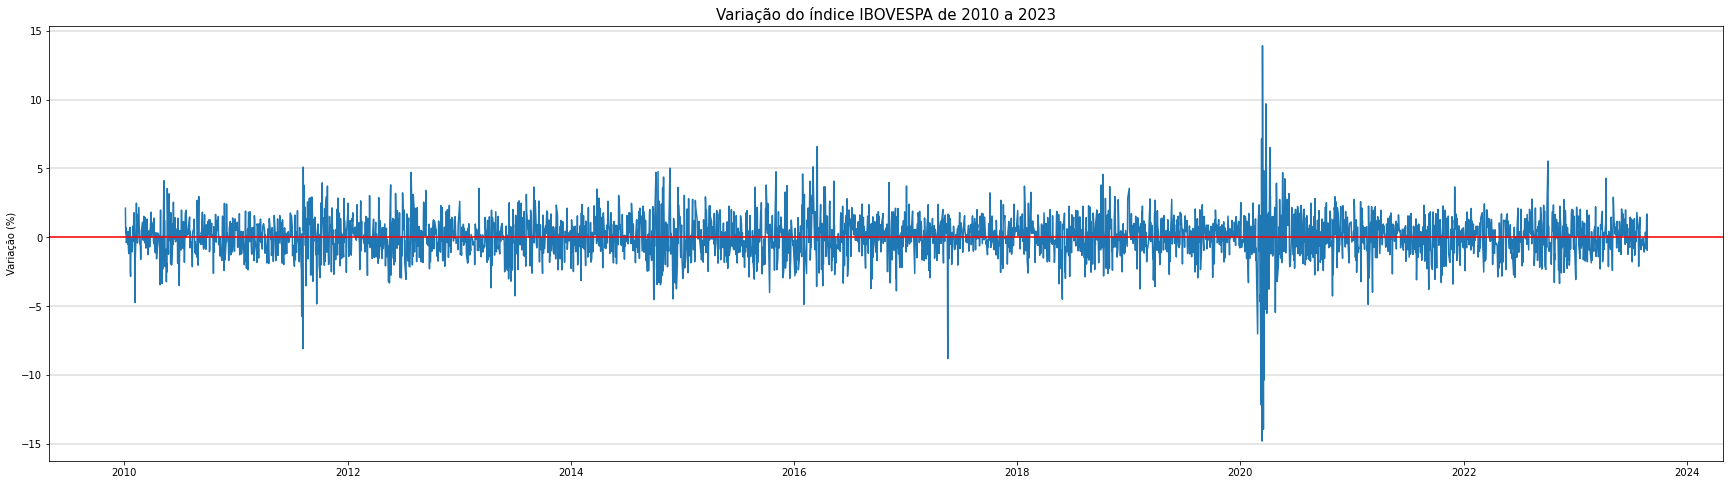

In [14]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='variacao', ax=ax)
ax.axhline(y=0, color='red')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Variação (%)')

plt.show()

Percebe-se um gráfico com muitos altos e baixos, porém com a maioria dos valores entre -5% e +5% de variação. 

Ocorrem alguns pontos no gráfico em que a variação ultrapassa esses valores, com destaque novamente para o ano de 2020 que apresentou o comportamento mais incostante na série.

## Volume

Total de valores negociados no dia, em milhões R$

In [15]:
print(f'Volume máximo (milhões R$): {dados.volume.max()}')
print(dados.loc[dados.volume == dados.volume.max()]['ds'])

print('\n')

print(f'Volume mínimo (milhões R$): {dados.volume.min()}')
print(dados.loc[dados.volume == dados.volume.min()]['ds'])

Volume máximo (milhões R$): 981.63
3158   2010-11-25
Name: ds, dtype: datetime64[ns]


Volume mínimo (milhões R$): 1.0
3009   2011-07-04
Name: ds, dtype: datetime64[ns]


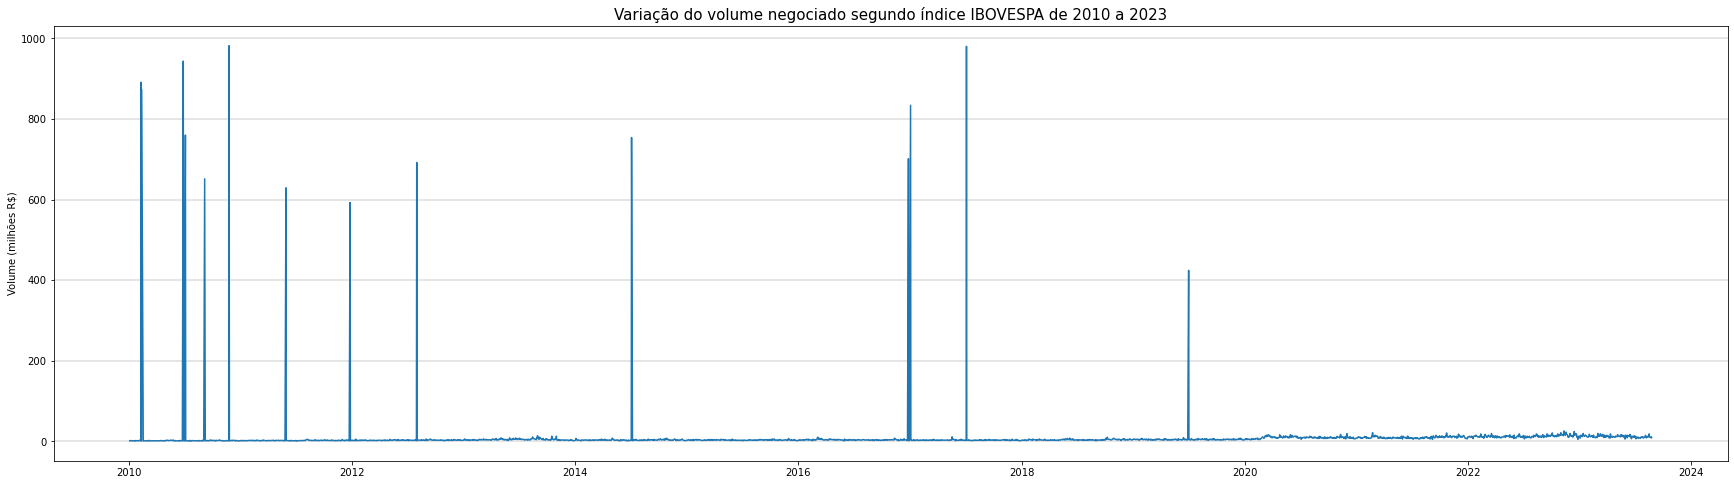

In [16]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='volume', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do volume negociado segundo índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Volume (milhões R$)')

plt.show()

O gráfico indica outliers muito acima do normal para os valores de volume negociados em bolsa, é um indício que a base de dados pode ter inconsistências nesse sentido.

Checando na base original, foi verificado que existiam valores na unidade de milhares de R$ em meio à grande maioria das linhas representadas em milhões de R$. Ou seja, os outliers que surgiram na verdade devem ser divididos por 1000 para ajustá-los para a unidade milhões de R$

In [17]:
# Linhas da base com volume em milhares de R$
dados.loc[dados.volume > 100]

,ds,y,abertura,max,min,volume,variacao
1034,2019-07-01,101.340,100.973,102.432,100.973,424.32,0.37
1523,2017-07-04,63.232,63.268,63.346,63.076,980.07,-0.08
1647,2017-01-02,59.589,60.227,60.227,59.371,833.73,-1.06
1651,2016-12-26,58.620,57.941,58.781,57.941,701.23,1.18
2266,2014-07-04,54.056,53.893,54.087,53.704,753.84,0.34
2740,2012-07-31,56.097,57.243,57.466,56.097,692.08,-2.00
2888,2011-12-26,57.669,57.702,57.856,57.669,592.75,-0.05
3033,2011-05-30,63.954,64.295,64.460,63.915,629.04,-0.53
3158,2010-11-25,69.362,69.634,69.780,69.362,981.63,-0.38
3212,2010-09-06,66.747,66.679,66.949,66.380,651.48,0.10


In [18]:
# Conversão para milhões de R$
dados.loc[dados.volume > 100, 'volume'] = dados.volume/1000

In [19]:
dados.loc[dados.volume > 100]

,ds,y,abertura,max,min,volume,variacao


In [20]:
print(f'Volume máximo (milhões R$): {dados.volume.max()}')
print(dados.loc[dados.volume == dados.volume.max()]['ds'])

print('\n')

print(f'Volume mínimo (milhões R$): {dados.volume.min()}')
print(dados.loc[dados.volume == dados.volume.min()]['ds'])

Volume máximo (milhões R$): 26.03
197   2022-11-10
Name: ds, dtype: datetime64[ns]


Volume mínimo (milhões R$): 0.42432
1034   2019-07-01
Name: ds, dtype: datetime64[ns]


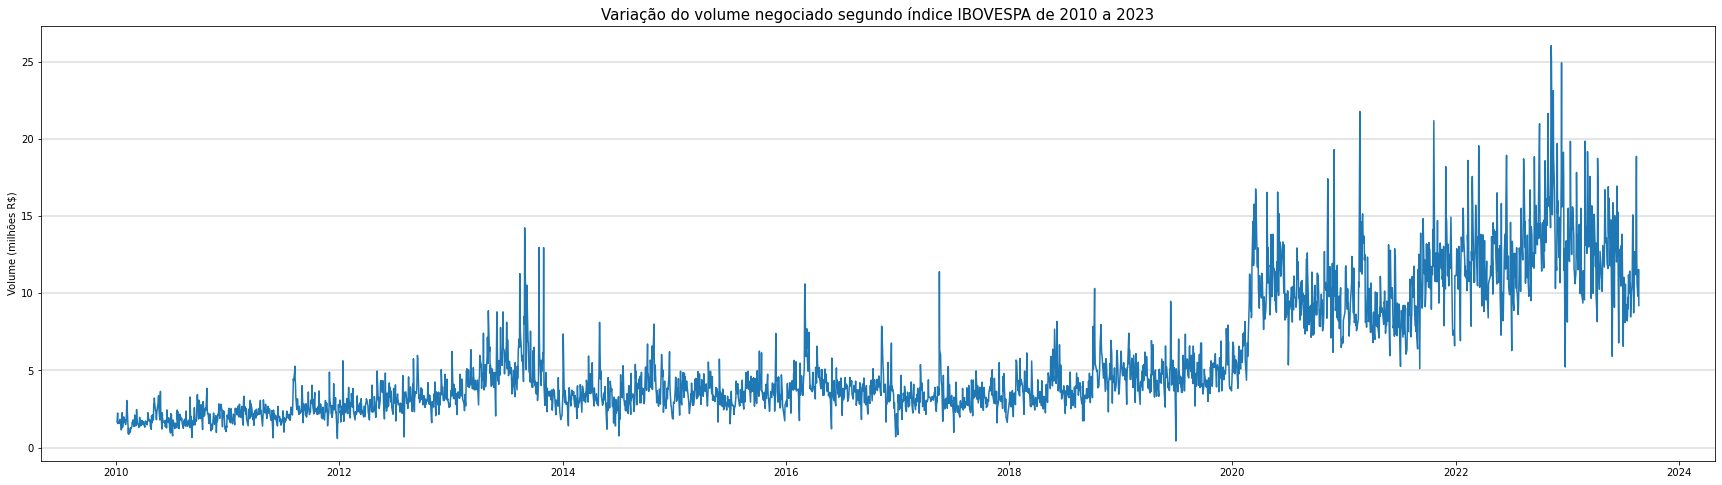

In [21]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='volume', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do volume negociado segundo índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Volume (milhões R$)')

plt.show()

Agora, o gráfico ilustra bem a evolução do mercado variável no Brasil. É visível que, até meados de 2019, o volume de negociações sofreu pouca alteração com uma leve tendência de crescimento.

Com a redução nas taxas de juros e Selic, e consequentemente a baixa nos investimentos de Renda Fixa, o mercado de Renda Variável teve um "boom" a partir do ano de 2020.

https://www.cnnbrasil.com.br/economia/numero-de-investidores-na-bolsa-cresce-15-em-2022-apostando-na-diversificacao/

## Diferença entre índice mínimo e máximo diário

Com a diferença entre as variáveis "min" e "max" é possível identificar dias em que o índice IBOVESPA sofreu maior alteração durante as próprias negociações do dia. 

Desta forma, pode-se verificar dias atípicos, possivelmente causados por fatores e eventos político-econômicos importantes, que resultaram na flutuação do índice durante o período de um dia.

In [22]:
dados['dif_min_max'] = dados['max'] - dados['min']
dados

,ds,y,abertura,max,min,volume,variacao,dif_min_max
0,2023-08-24,117.026,118.135,118.136,116.848,9.20,-0.94,1.288
1,2023-08-23,118.135,116.160,118.135,116.159,11.54,1.70,1.976
2,2023-08-22,116.156,114.433,116.286,114.433,9.83,1.51,1.853
3,2023-08-21,114.429,115.404,115.425,114.067,9.79,-0.85,1.358
4,2023-08-18,115.409,114.973,115.729,114.423,10.60,0.37,1.306
...,...,...,...,...,...,...,...,...
3376,2010-01-08,70.263,70.455,70.766,70.158,1.63,-0.27,0.608
3377,2010-01-07,70.451,70.723,70.723,70.045,1.55,-0.39,0.678
3378,2010-01-06,70.729,70.237,70.937,70.016,2.24,0.70,0.921
3379,2010-01-05,70.240,70.046,70.595,69.928,1.98,0.28,0.667


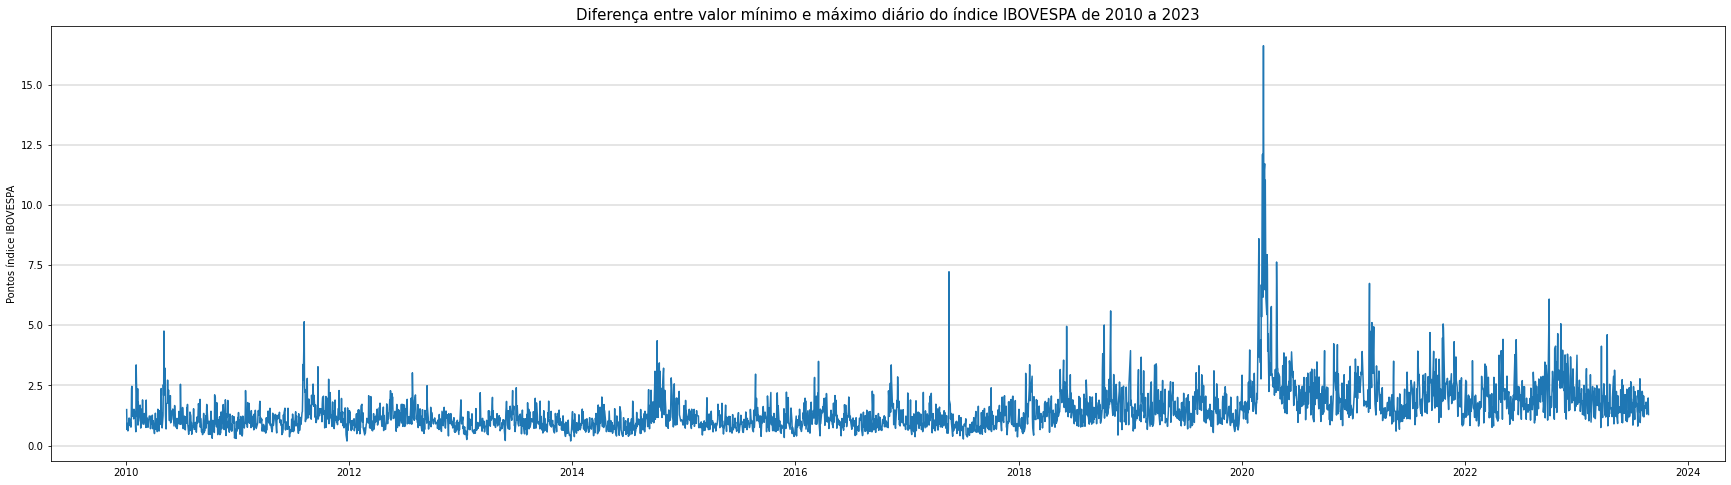

In [23]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='dif_min_max', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Diferença entre valor mínimo e máximo diário do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

In [24]:
print('Número de dias com diferença entre mínimo e máximo maior que 5%:')
dados.loc[dados.dif_min_max > 5].ds.dt.year.value_counts()

Número de dias com diferença entre mínimo e máximo maior que 5%:


2020    19
2021     3
2022     2
2018     2
2017     1
2011     1
Name: ds, dtype: int64

Este resultado reforça mais uma vez o comportamento atípico do IBOVESPA a partir de 2020. Possivelmente, 2021 e 2022 aparecem em seguida no rankin também por reflexo dos efeitos da crise causada pela pandemia.

## Fechamento

In [25]:
print(f'Índice máximo no fechamento: {dados.y.max()}')
print(dados.loc[dados.y == dados.y.max()]['ds'])

print('\n')

print(f'Índice máximo no fechamento: {dados.y.min()}')
print(dados.loc[dados.y == dados.y.min()]['ds'])

Índice máximo no fechamento: 130.776
555   2021-06-07
Name: ds, dtype: datetime64[ns]


Índice máximo no fechamento: 37.497
1881   2016-01-26
Name: ds, dtype: datetime64[ns]


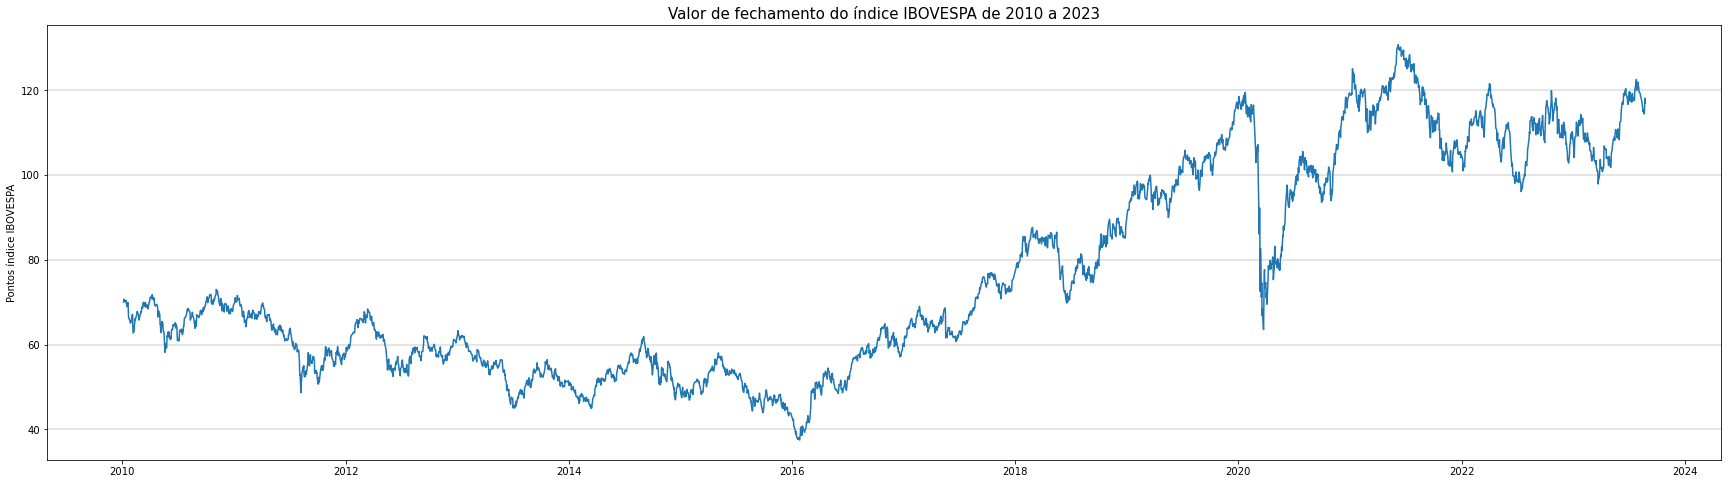

In [26]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='y', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Valor de fechamento do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

Analisando a série temporal do valor de fechamento diário do IBOVESPA, de maneira geral ficam evidentes quatro momentos distintos:

1. Tendência de queda de 2010 a 2016
2. Alta tendência de subida entre 2016 e 2020
3. Queda abrupta com a pandemia em 2020
4. Retomada da normalidade a partir do final de 2021, com série variando em momentos de queda e alta

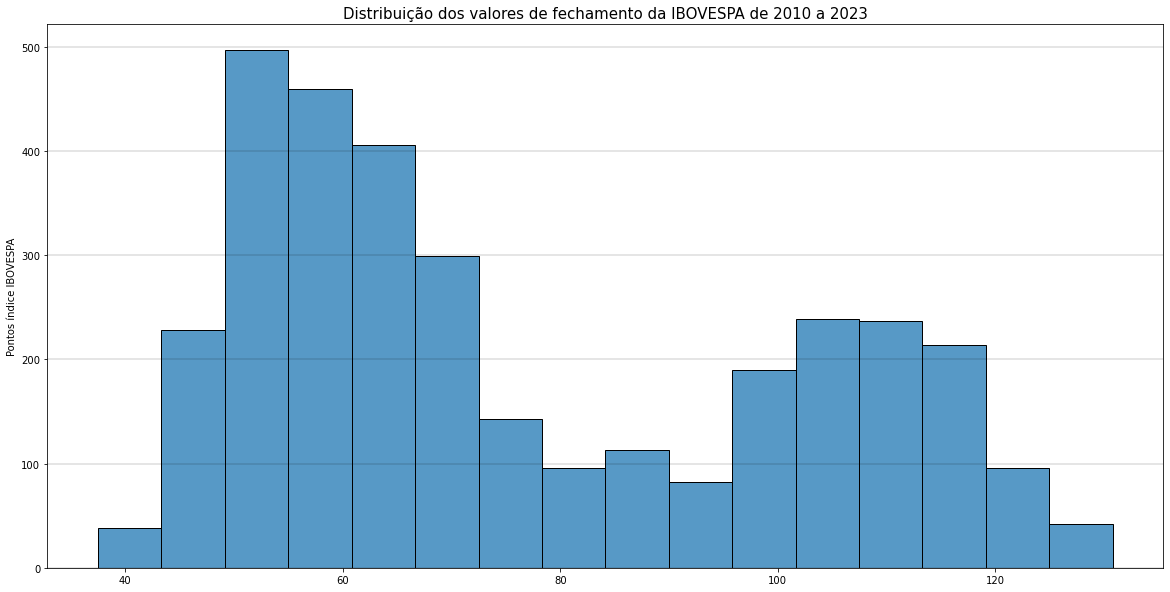

In [27]:
fig, ax = plt.subplots(figsize=(20,10))

sns.histplot(dados, x='y', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Distribuição dos valores de fechamento da IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

A série temporal se divide em basicamente dois grupos de acordo com o valor de fechamento. Primeiramente, o maior grupo que representa dias com valor de fechamento entre 50 e 80 pontos, relacionado principalmente aos de 2010 a 2016.

Já o segundo grande grupo concentra dias com valor de fechamento superior aos 100 pontos. Este grupo está relacionado principalmente ao período posterior ao ano de 2019.

## Volume x Fechamento

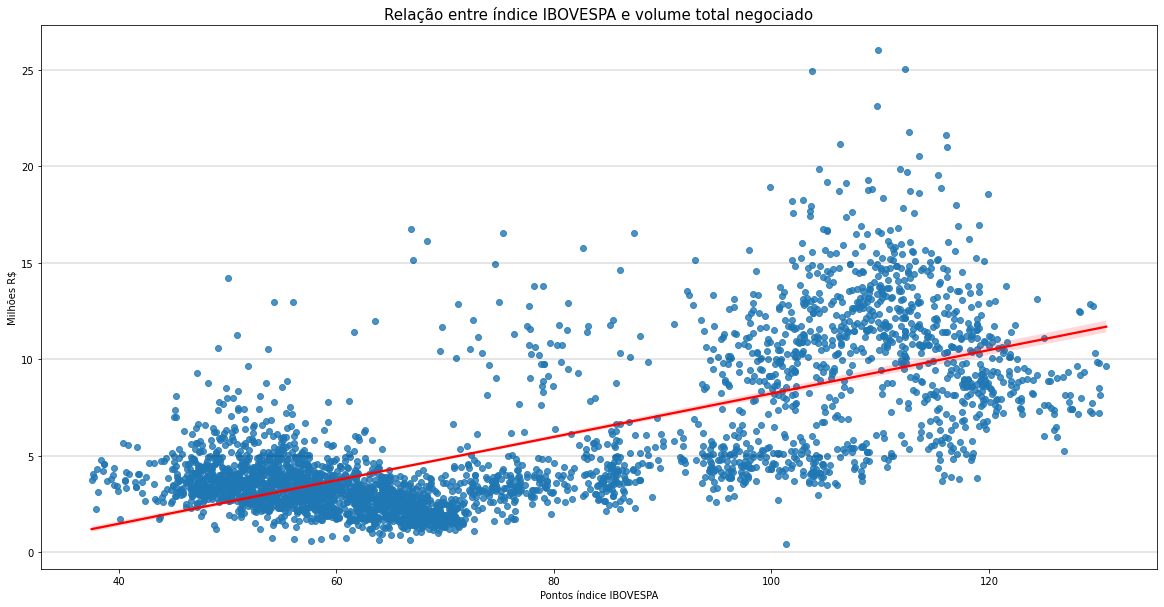

In [28]:
fig, ax = plt.subplots(figsize=(20,10))

sns.regplot(dados, x='y', y='volume', ax=ax, line_kws={'color':'red'})

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Relação entre índice IBOVESPA e volume total negociado', fontsize=15)
ax.set_xlabel('Pontos índice IBOVESPA')
ax.set_ylabel('Milhões R$')

plt.show()

In [29]:
print(dados[['y','volume']].corr())

               y    volume
y       1.000000  0.698497
volume  0.698497  1.000000


Neste gráfico de dispersão é possível visualizar uma forte correlação entre o valor do índice IBOVESPA e o volume negociado em bolsa. A correlação calculada é de 0.70, também um valor bastante alto.

# Série temporal original

## Componentes da série

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

Para ser possível visualizar as componentes da série, é necessário preencher as lacunas na série temporal causada por fins de semana e feriados.

Será utilizado o método ffill, que preenche valores NaN com o último valor válido da coluna.

In [31]:
dados_date_index = dados[['ds','y']].copy()
dados_date_index.index = pd.to_datetime(dados_date_index.ds, format='%Y-%m-%d')
dados_date_index.drop(columns=['ds'], inplace=True)
dados_date_index = dados_date_index.asfreq('d')
dados_date_index.fillna(method='ffill', inplace=True)
dados_date_index

,y
ds,
2010-01-04,70.045
2010-01-05,70.240
2010-01-06,70.729
2010-01-07,70.451
2010-01-08,70.263
...,...
2023-08-20,115.409
2023-08-21,114.429
2023-08-22,116.156


In [32]:
result = seasonal_decompose(dados_date_index)

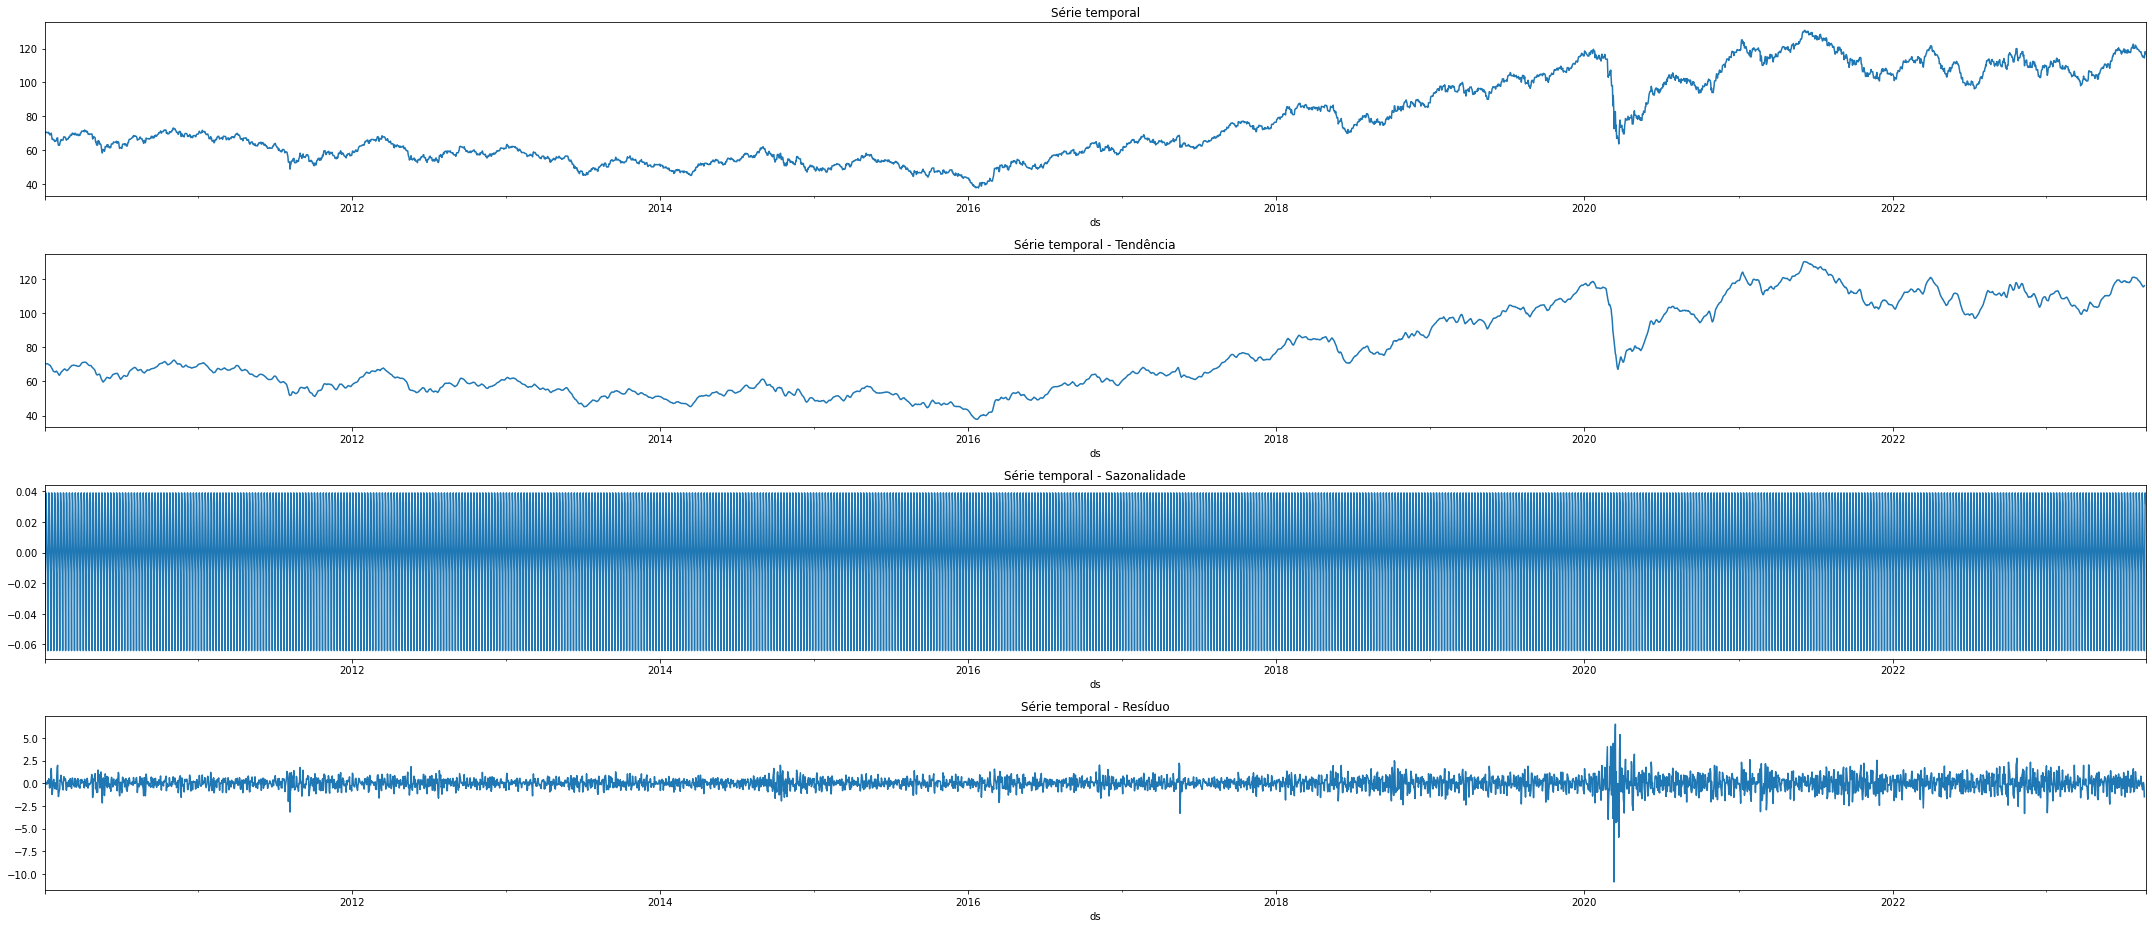

In [33]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

Não foi possível extrair insights muito valiosos com a decomposição da série temporal em seus componentes. A tendência representa a mesma curva da própria série porém um pouco mais suavizada.

A sazonalidade têm padrão caótico, indicando que não é sazonalidade aparente nos dados, o que faz bastante sentido.

Já o resíduo reforça a ideia de 2020 ser um ano fora do padrão de comportamento da curva.

## Teste ADF

- Teste ADF -> verificar se uma série temporal é estacionária ou não

- H0 = hipótese nula (não é estacionária)
- H1 = hipótese alternativa (é estacionária)

In [34]:
from statsmodels.tsa.stattools import adfuller

result_adfuller = adfuller(dados_date_index.y)

In [35]:
print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

Teste ADF
Teste estatístico: -0.9930767867580196
P-value: 0.7557810012330979


Valores críticos:
1%: -3.4316669649844727
5%: -2.8621219552891963
10%: -2.5670797756478825


Não é estacionária!

## Média móvel

In [36]:
# Rolling = calcula estatísticas com base em intervalos no df. Neste caso, média móvel
ma = dados_date_index.rolling(12). mean()

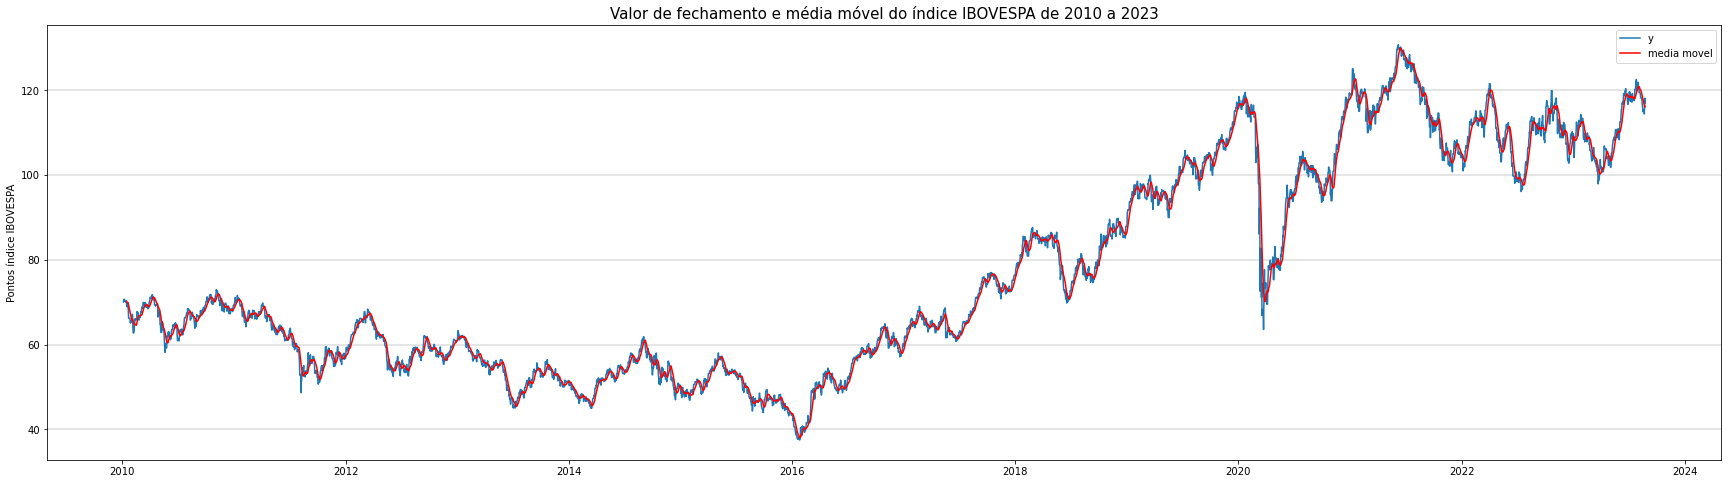

In [37]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_date_index, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma, x='ds', y='y', ax=ax, color='r', label='media movel')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Valor de fechamento e média móvel do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

Assim como a componente de tendência, a média móvel parece representar o mesmo comportamento da série original porém de maneira suavizada

# Série temporal com transformada logarítmica

## Média móvel

In [38]:
dados_log = np.log(dados_date_index)
ma_log = dados_log.rolling(12).mean()

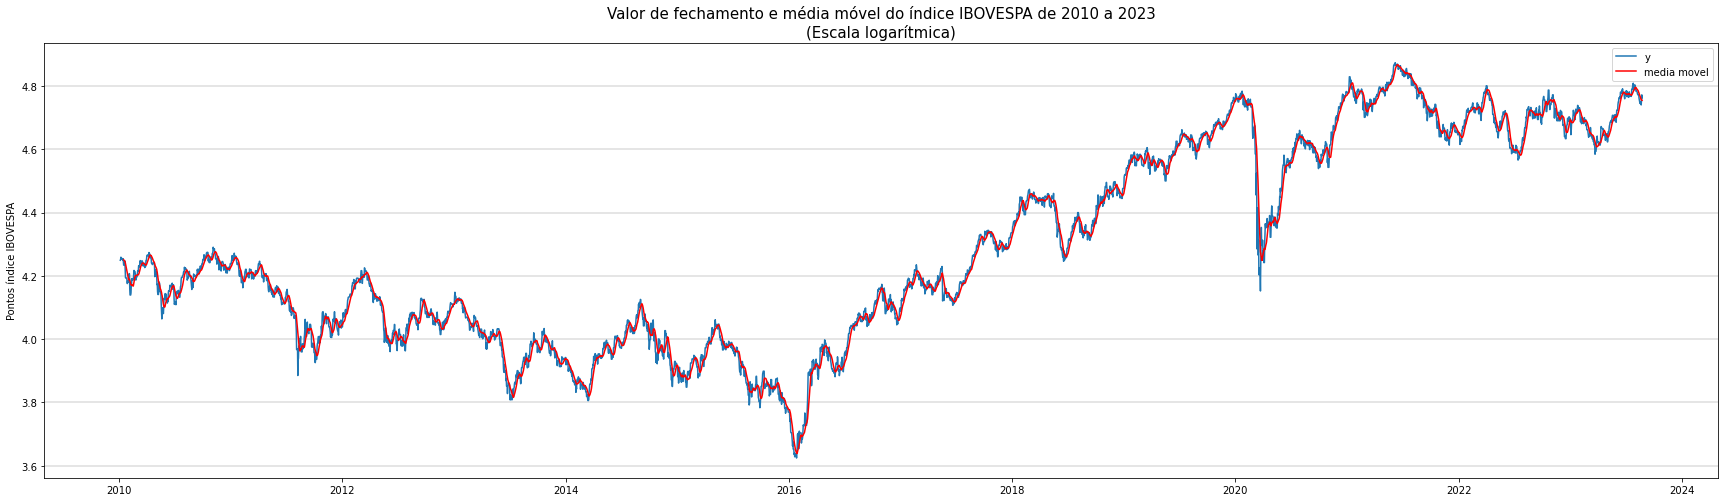

In [39]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_log, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_log, x='ds', y='y', ax=ax, color='r', label='media movel')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Valor de fechamento e média móvel do índice IBOVESPA de 2010 a 2023\n(Escala logarítmica)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

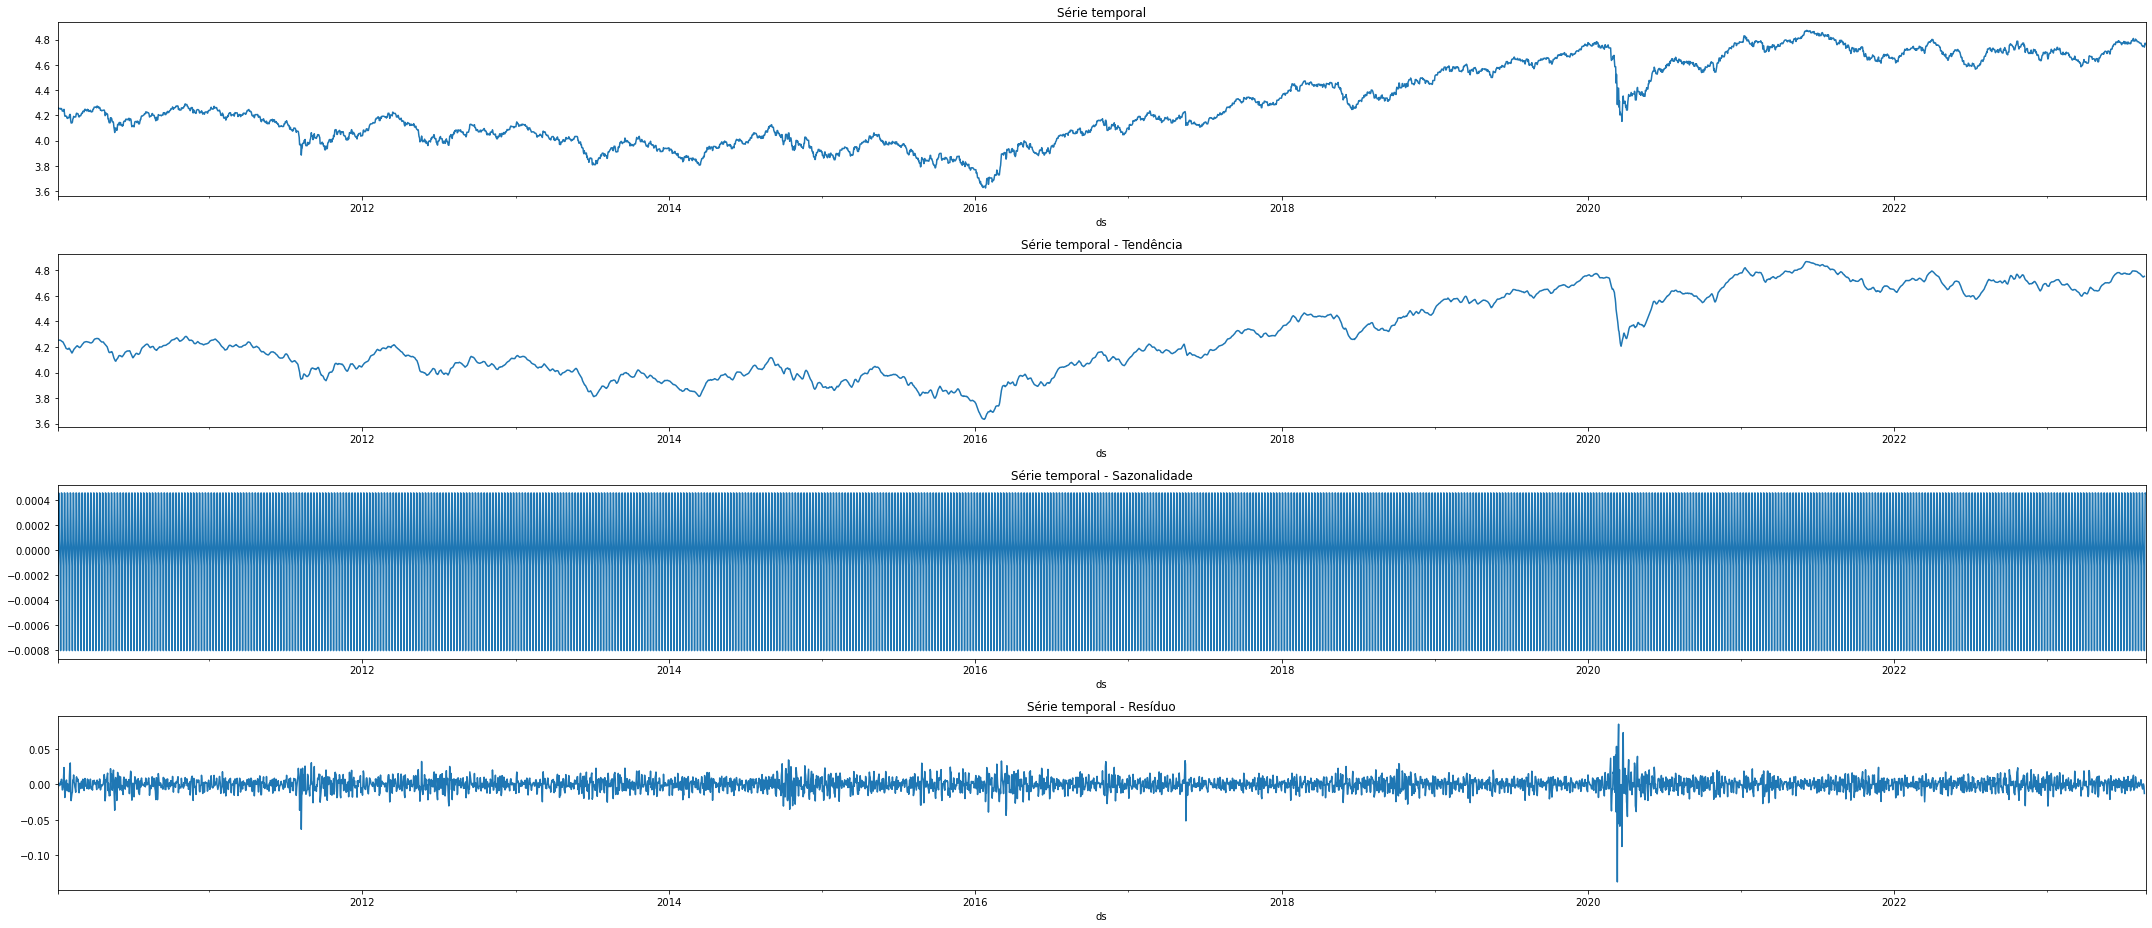

In [40]:
result = seasonal_decompose(dados_log)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF

In [41]:
result_adfuller = adfuller(dados_log.y)

print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

Teste ADF
Teste estatístico: -1.0153285502014142
P-value: 0.7476325896137215


Valores críticos:
1%: -3.4316669649844727
5%: -2.8621219552891963
10%: -2.5670797756478825


Portanto, aplicando a transformada logarítmica não ocorreram mudanças significativas na série temporal.

# Diferença entre série temporal logarítmica e média móvel

## Média móvel

In [42]:
dados_log_subt = dados_log - ma_log
ma_subt = dados_log_subt.rolling(12).mean()
std_subt = dados_log.rolling(12).std()
dados_log_subt.dropna(inplace=True)

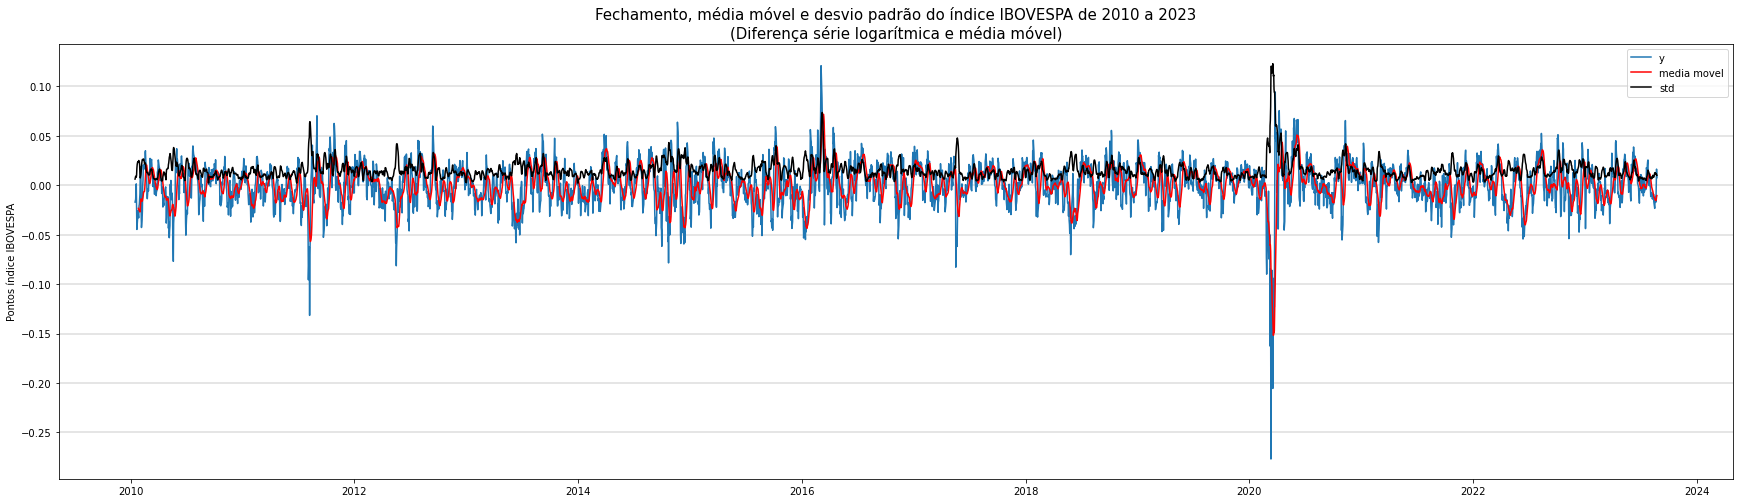

In [43]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_log_subt, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_subt, x='ds', y='y', ax=ax, color='r', label='media movel')
sns.lineplot(std_subt, x='ds', y='y', ax=ax, color='black', label='std')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Fechamento, média móvel e desvio padrão do índice IBOVESPA de 2010 a 2023\n(Diferença série logarítmica e média móvel)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

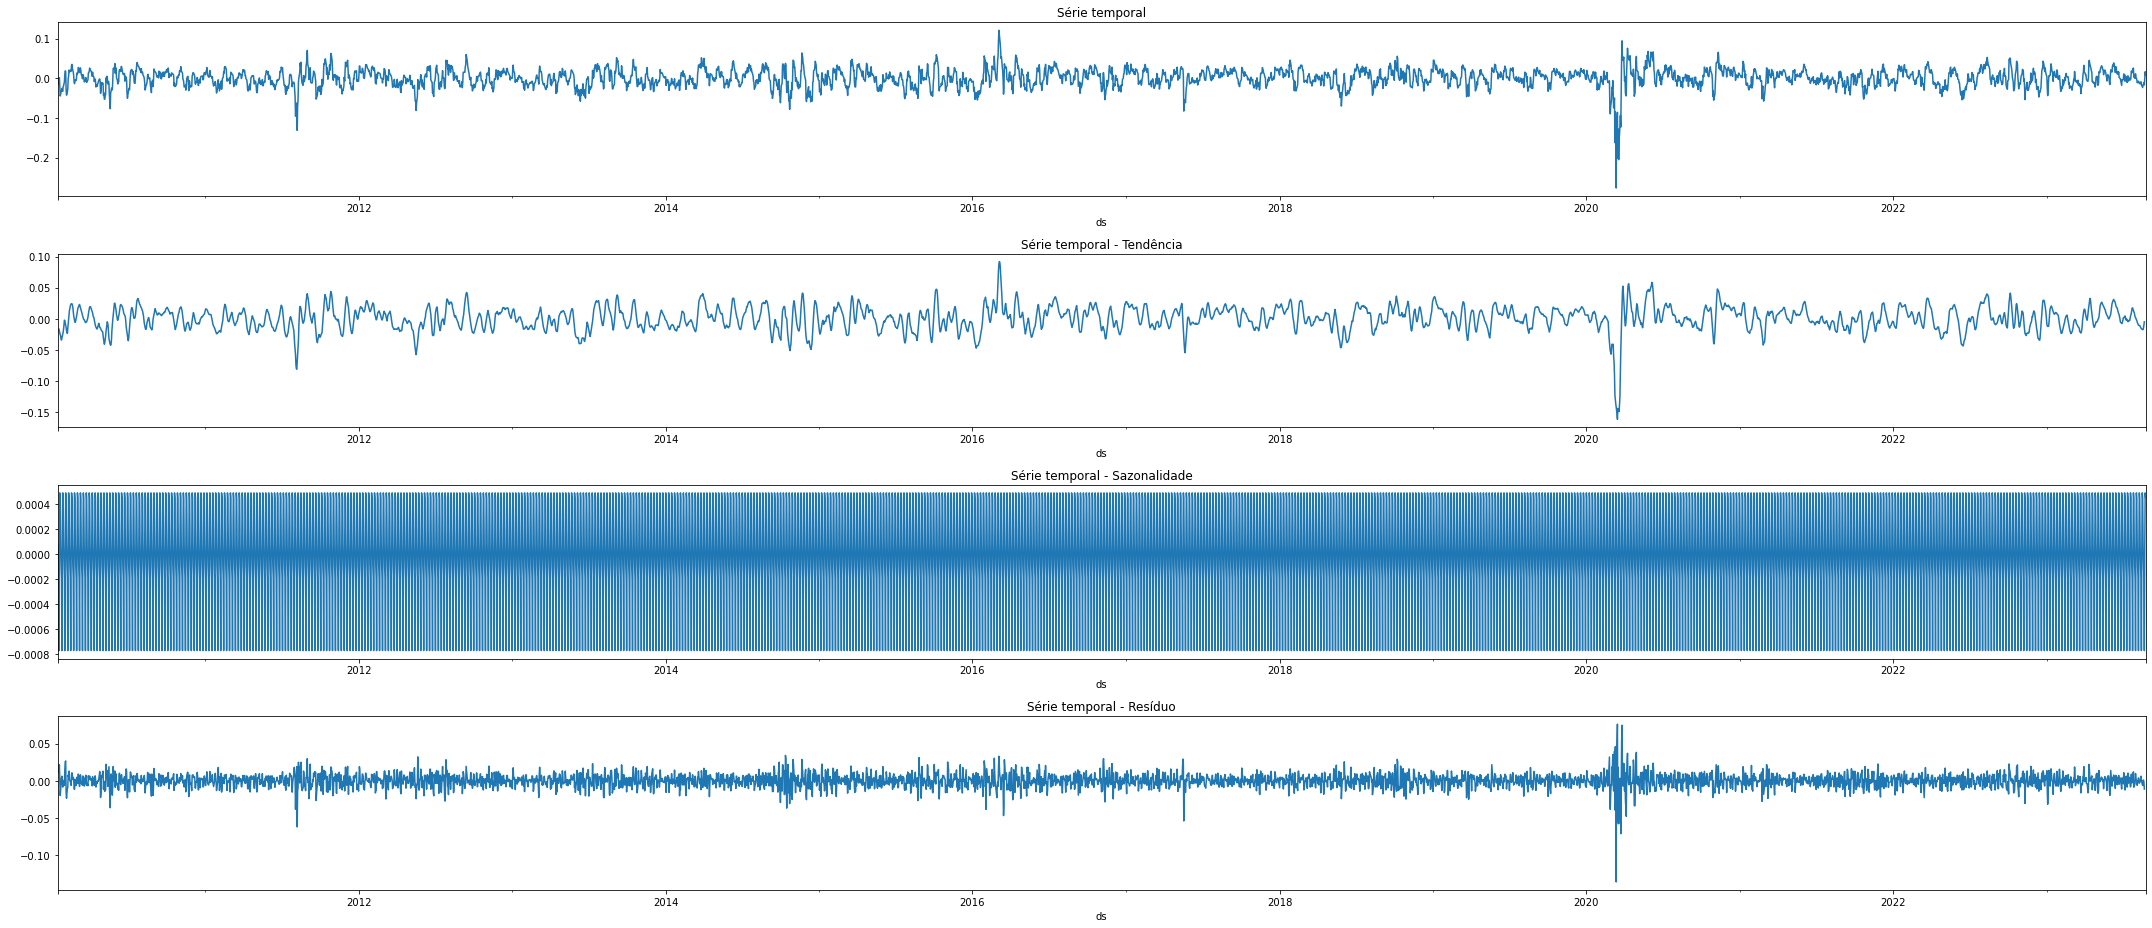

In [44]:
result = seasonal_decompose(dados_log_subt)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF

In [45]:
result_adfuller = adfuller(dados_log_subt.y)

print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

if(result_adfuller[1] < result_adfuller[4]['5%']):
    print('H0 nula confirmada, não é estacionária')
else:
    print('H1 alternativa confirmada, é estacionária')

Teste ADF
Teste estatístico: -14.734478957402658
P-value: 2.6285362454064732e-27


Valores críticos:
1%: -3.4316698889560326
5%: -2.8621232470799196
10%: -2.5670804633192237
H1 alternativa confirmada, é estacionária


Desta vez, a diferença entre a série em escala logarítmica e a média móvel resultou em uma série temporal mais constante, visualmente com caráter estacionário.

Tal hipótese foi confirmada com o teste ADF que indicou uma série temporal estacionária.

# Série temporal derivada

## Média móvel

In [46]:
dados_diff = dados_log_subt.diff(1)
ma_diff = dados_diff.rolling(12).mean()
std_diff = dados_diff.rolling(12).std()
dados_diff.dropna(inplace=True)

dados_diff

,y
ds,
2010-01-16,0.001279
2010-01-17,0.001511
2010-01-18,0.007693
2010-01-19,0.007937
2010-01-20,-0.022266
...,...
2023-08-20,0.002616
2023-08-21,-0.005679
2023-08-22,0.016539


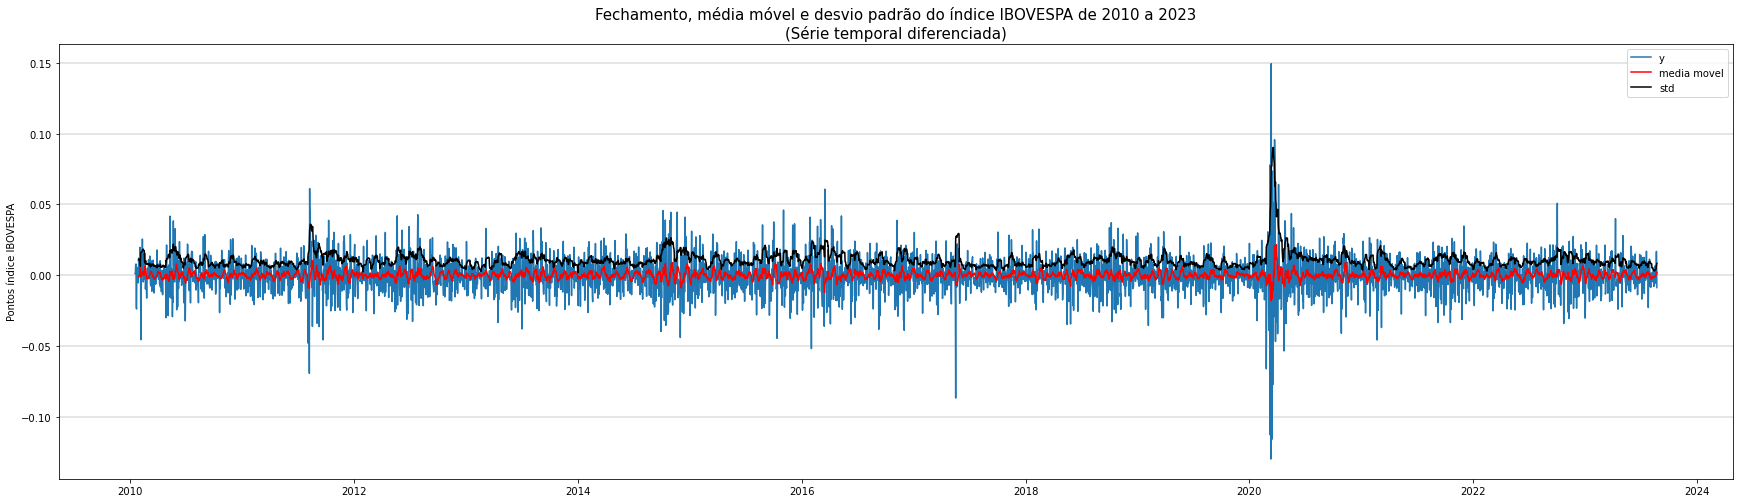

In [47]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_diff, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_diff, x='ds', y='y', ax=ax, color='r', label='media movel')
sns.lineplot(std_diff, x='ds', y='y', ax=ax, color='black', label='std')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Fechamento, média móvel e desvio padrão do índice IBOVESPA de 2010 a 2023\n(Série temporal diferenciada)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

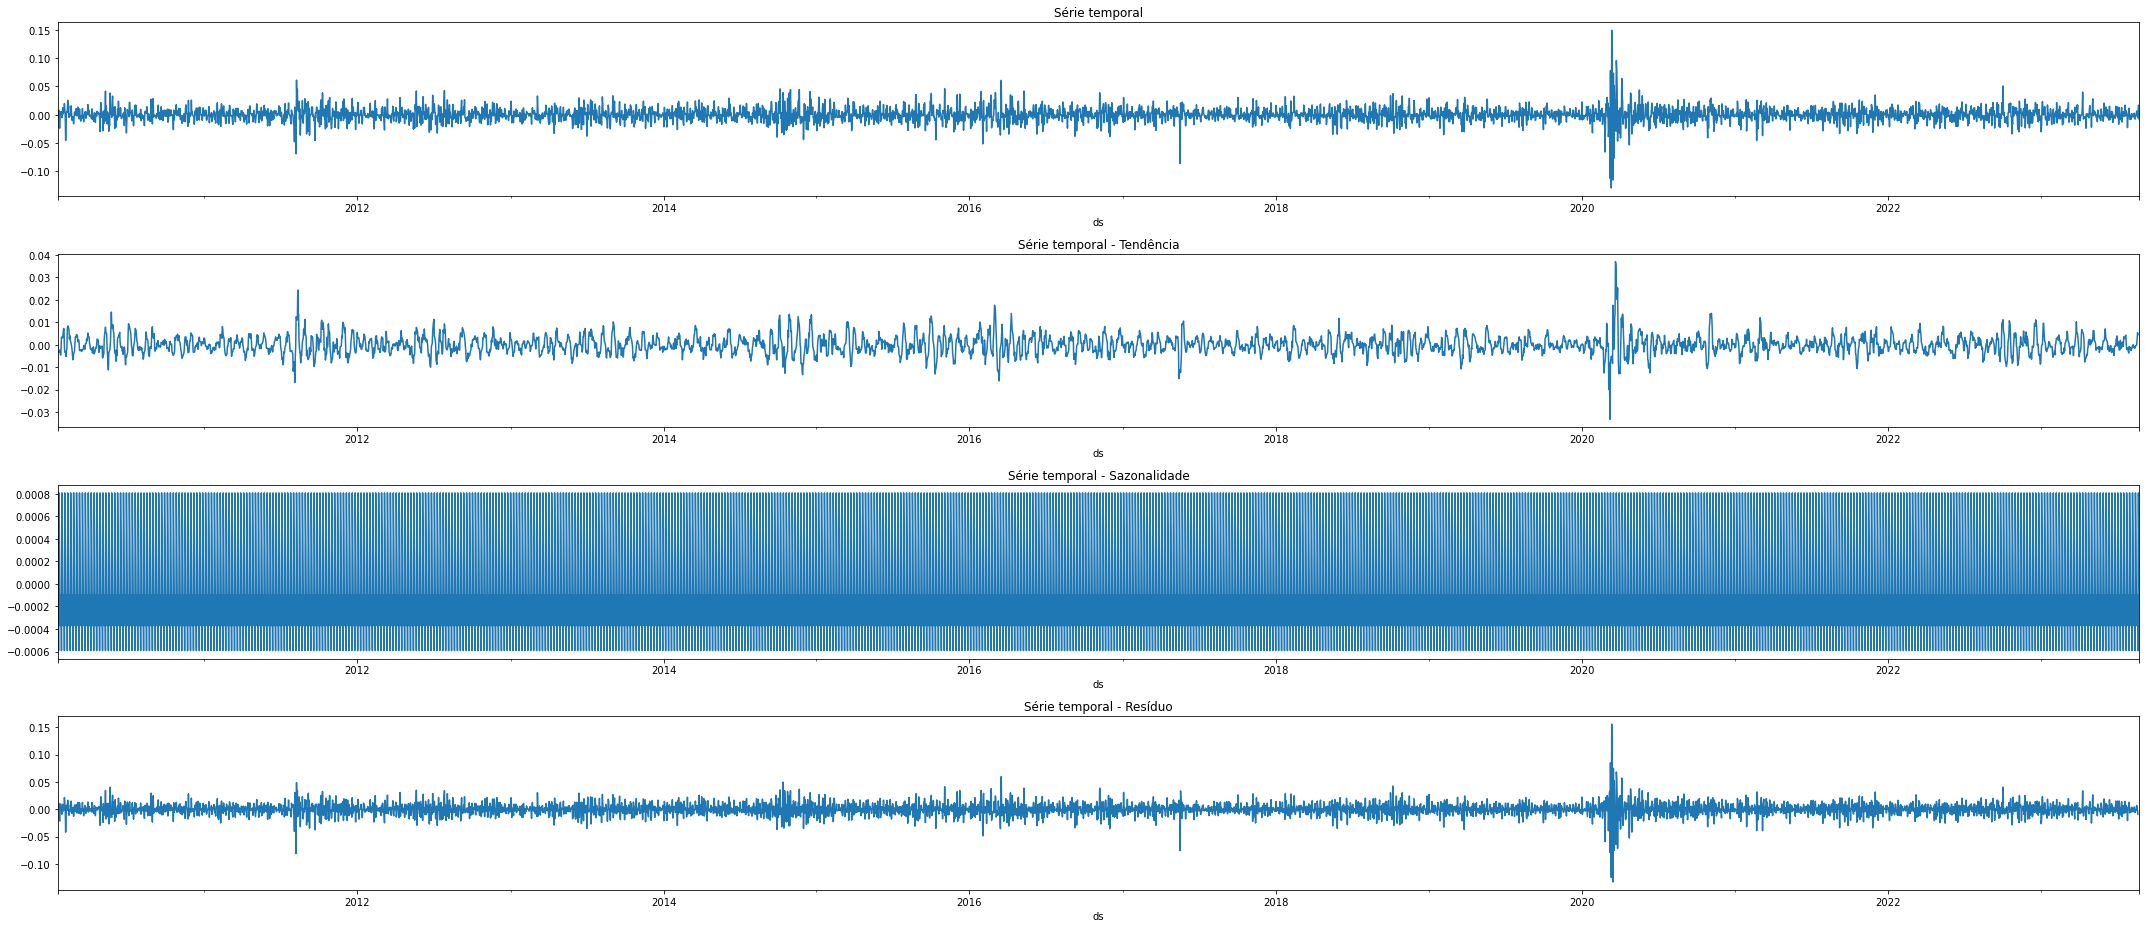

In [48]:
result = seasonal_decompose(dados_diff)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF

In [49]:
result_adfuller = adfuller(dados_diff.y)

print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

if(result_adfuller[1] < result_adfuller[4]['5%']):
    print('H0 nula confirmada, não é estacionária')
else:
    print('H1 alternativa confirmada, é estacionária')

Teste ADF
Teste estatístico: -19.258794383301552
P-value: 0.0


Valores críticos:
1%: -3.4316755072912444
5%: -2.862125729218594
10%: -2.5670817846605103
H1 alternativa confirmada, é estacionária


Novamente, tem-se uma série temporal visualmente muito mais constante, com aspecto estacionário.

O o teste ADF confirmar a hipótese de série temporal estacionária.

# ACF e PACF

Com as séries temporais estacionárias obtidas a partir da diferenciação da série original, podem ser calculados os valores de ACF (Autocorrelation Function) e PACF (Partial Autocorrelation Function).

Esta análise traz importantes resultados sobre a sazonalidade e a randomicidade da série temporal, bem como indica o grau de correlação entre os próprios intervalos de tempo existentes na série temporal.

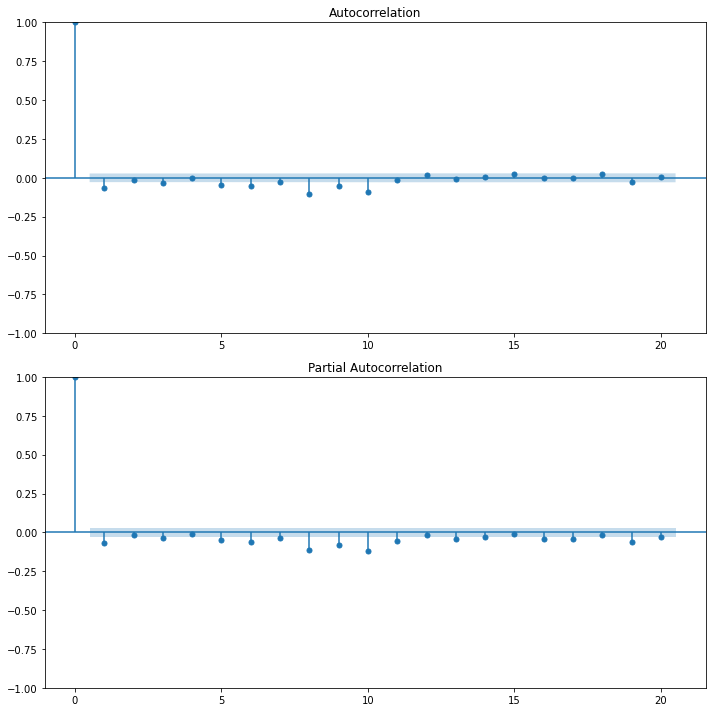

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

plot_acf(dados_diff.y, lags=20, ax=ax[0])
plot_pacf(dados_diff.y, lags=20, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

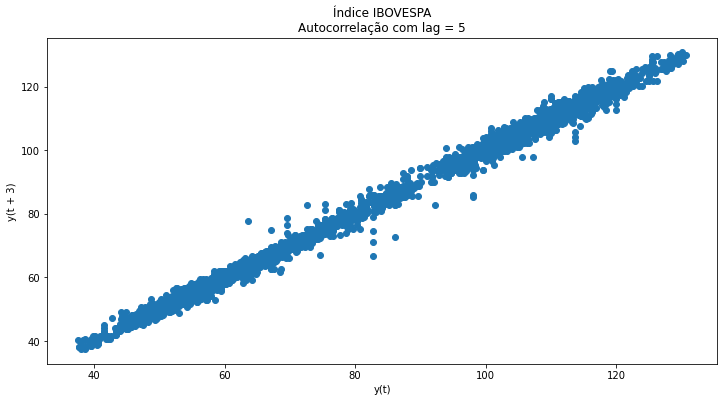

In [51]:
plt.figure(figsize=(12, 6))

lag_plot(dados_date_index.y, lag=3)

plt.title('Índice IBOVESPA\nAutocorrelação com lag = 5')

plt.show()

Com os gráficos, confirma-se a existência de autocorrelação na série temporal, especialmente com lags pequenos, ou seja, em um intervalo de dias reduzido.

É perceptível uma forte autocorrelação na série temporal do IBOVESPA em intervalos de 5 dias (lag = 5), ou seja, analisando um período de 5 dias geralmente serão observados valores do índice muito semelhantes.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

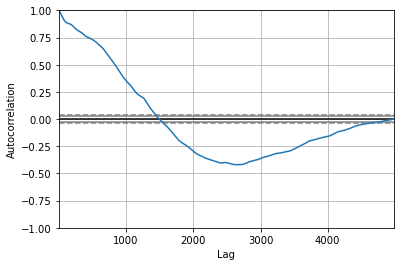

In [103]:
autocorrelation_plot(dados_date_index)

# Modelo ARIMA

**Parâmetros:**
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

## Datasets de treino e teste

In [52]:
train_set = dados_date_index.loc[dados_date_index.index < '2022-01-01']
test_set = dados_date_index.loc[dados_date_index.index >= '2022-01-01']

print(len(train_set))
print(len(test_set))

4380
601


## Modelo ARIMA padrão

Será usado um lag de 5 dias no parãmetro p, tendo em vista que há forte autocorrelação nesse intervalo na série temporal.

In [140]:
arima_model = ARIMA(train_set, order=(5,1,0))

In [141]:
arima_model_fit = arima_model.fit()

In [142]:
y_pred = arima_model_fit.forecast(len(test_set))

In [146]:
residuals = pd.DataFrame(arima_model_fit.resid)

### Curva prevista

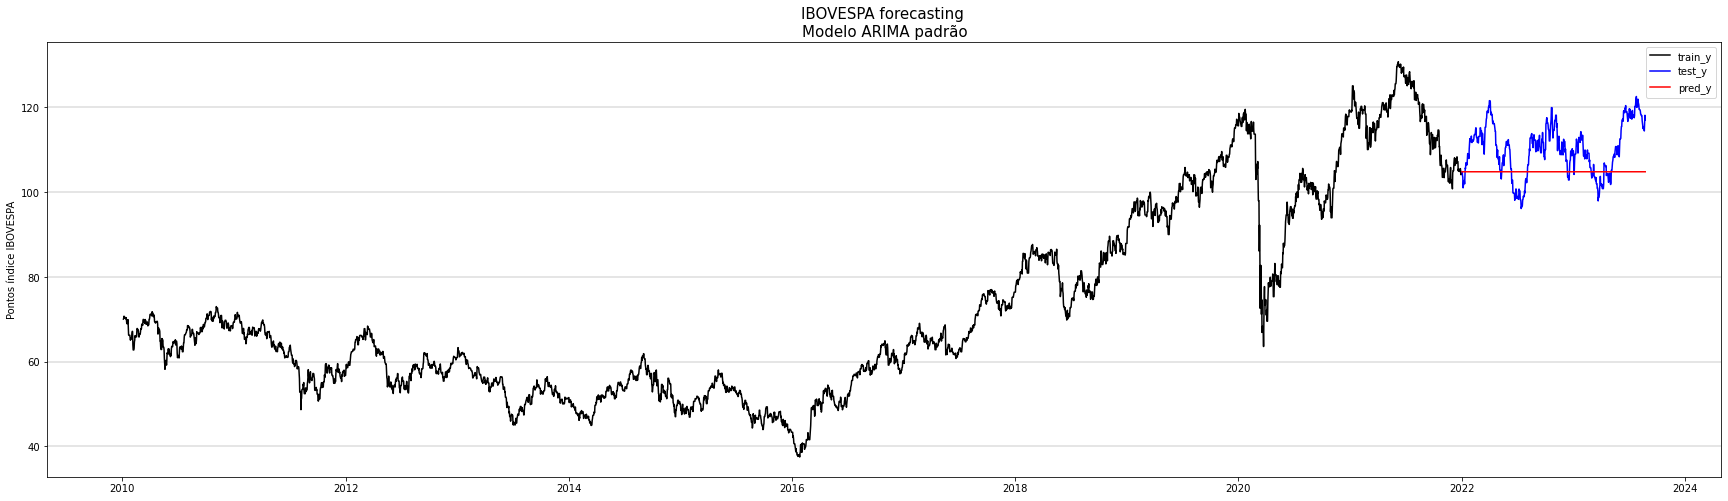

In [143]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(train_set, x='ds', y='y', ax=ax, label='train_y', color='black')
sns.lineplot(test_set, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, ax=ax, color='red', label='pred_y')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('IBOVESPA forecasting \nModelo ARIMA padrão', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

### WMAPE

In [153]:
wmape_arima_padrao = wmape(test_set['y'].values, y_pred)
print(f"WMAPE: {wmape_arima_padrao:.2%}")

WMAPE: 6.12%


In [152]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4380
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5978.138
Date:                Wed, 30 Aug 2023   AIC                          11968.276
Time:                        08:00:00   BIC                          12006.584
Sample:                    01-04-2010   HQIC                         11981.793
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0843      0.006    -13.883      0.000      -0.096      -0.072
ar.L2         -0.0032      0.007     -0.490      0.624      -0.016       0.010
ar.L3         -0.0076      0.007     -1.067      0.2

Apesar do valor baixo no WMAPE, analisando a curva é visível que o modelo não performou bem, pois foi prevista uma linha constante, muito distante do comportamento da série temporal que possui diversos altos e baixos.

Uma das hipóteses é que o modelo está utilizando o comportamente do dataset de treino para fazer todas as previsões do dataset de teste, quando, na verdade, a cada nova previsão o modelo deveria passar por um novo ajuste de acordo com o valor previsto.

## Modelo ARIMA "retroalimentado"

Para isso, será aplicada a lógica de um laço de repetiçao, em que a cada execução uma nova previsão é realizada e um novo ajuste é feito no modelo ARIMA.

In [189]:
y_pred_step = []
history = [y for y in train_set.y.values]

In [253]:
history.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-09', '2010-01-10', '2010-01-11',
               '2010-01-12', '2010-01-13',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='ds', length=4380, freq='D')

In [259]:
import warnings
warnings.filterwarnings("ignore")

In [276]:
history = train_set.copy()

for i in range(len(test_set))[:20]:
    model_arima = ARIMA(history, order=(4,1,1))
    model_arima_fit = model_arima.fit()
    output = model_arima_fit.forecast(disp=0)
    yhat = output[0]
    y_pred_step.append(yhat)
    obs = test_set.values[i]
    history = history.append(pd.DataFrame({'y':obs}, index=[test_set.index[i]]))

    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=104.809684, expected=104.822000
predicted=104.797978, expected=104.822000
predicted=104.838202, expected=103.922000
predicted=103.998591, expected=103.514000
predicted=103.551287, expected=101.006000
predicted=101.224317, expected=101.561000
predicted=101.502844, expected=102.719000
predicted=102.628992, expected=102.719000
predicted=102.651820, expected=102.719000
predicted=102.726246, expected=101.945000
predicted=102.037253, expected=103.779000
predicted=103.628134, expected=105.686000
predicted=105.526253, expected=105.530000
predicted=105.502648, expected=106.928000
predicted=106.839996, expected=106.928000
predicted=106.971488, expected=106.928000
predicted=106.916006, expected=106.374000
predicted=106.452962, expected=106.668000
predicted=106.646540, expected=108.013000
predicted=107.904168, expected=109.102000
